In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

In [2]:
loaded_model = models.load_model(
    './lime_fsm_model_v2/', # path to saved model
    custom_objects=None,
    compile=True # model has already been compiled so set this to True
)

loaded_model

In [3]:
train_dir = '../data/chest_xray/train'
validation_dir = '../data/chest_xray/val'
test_dir = '../data/chest_xray/test'

In [4]:
def get_paths(directory):
    pneu_list = os.listdir(directory + '/PNEUMONIA')
    norm_list = os.listdir(directory + '/NORMAL')

    pneu_labels = [1 for img in pneu_list]
    norm_labels = [0 for img in norm_list]
    
    labels = pneu_labels + norm_labels

    pneu_path = [train_dir + '/PNEUMONIA/'+ img_id for img_id in pneu_list]
    norm_path = [train_dir + '/NORMAL/'+ img_id for img_id in norm_list]
    path_list = pneu_path + norm_path
    
    directory_df = pd.DataFrame(path_list, columns=['image_path'])
    directory_df['image_label']=labels

    return path_list, labels, directory_df

In [5]:
train_path_list, train_labels, train_df = get_paths(train_dir)

In [6]:
def preprocess_image(path_list):
    output = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0) # rescale should match what was used for model training
        output.append(x)
    return np.vstack(output)

In [7]:
images = preprocess_image(train_path_list)
images[0].shape

(299, 299, 3)

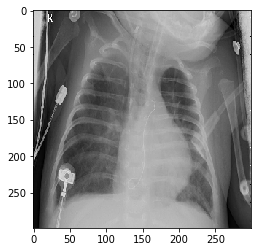

In [8]:
xray = images[0]
plt.imshow(xray);

In [9]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in loaded_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)

In [10]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
dense (Dense)                (None, 85)                59578965  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 86        
Total params: 59,579,947
Trainable params: 59,579,947
Non-trainable params: 0
_________________________________________________________________


(5216, 297, 297, 32)


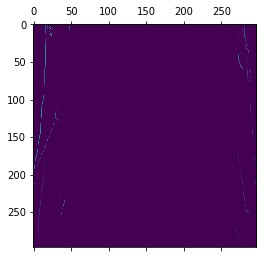

In [11]:
# Returns an array for each activation layer
activations = activation_model.predict(images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

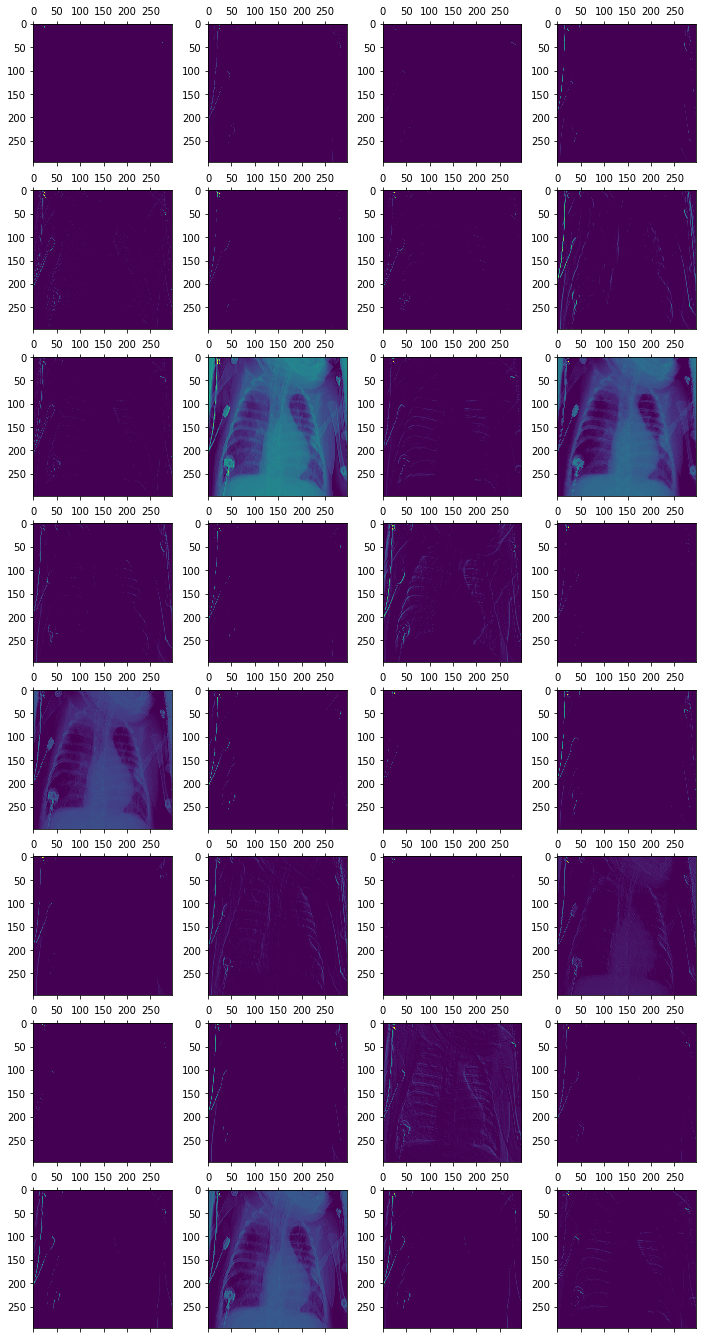

In [12]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

IndexError: too many indices for array

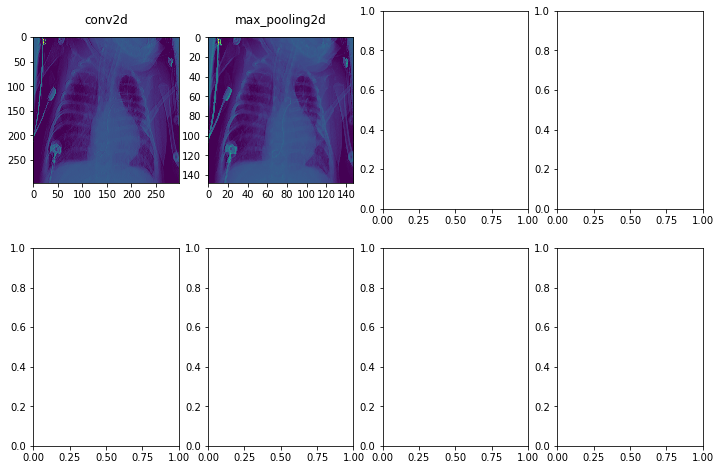

In [16]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in loaded_model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])